In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

import time
from tqdm import tqdm


<a id="makedf"></a>
# <center>Read in train, test and valid images and create train, test and validation data frames</center>

In [2]:
def make_dataframes():
    print('Enter the full path to the directory containing the train, test and valid sub directories')
    sdir=input(' ')
    dataset_names= ['train', 'test' ,'valid']
    train_path=os.path.join(sdir, 'train')
    test_path=os.path.join(sdir, 'test')
    valid_path=os.path.join(sdir, 'valid')
    path_list=[train_path, test_path, valid_path]   
    zip_list=zip(dataset_names, path_list)
    
    # generate train_df, test_df, valid_df
    for dataset, setpath in zip_list:
        filepaths=[]
        labels=[]
        classes=sorted(os.listdir(setpath))
        for klass in classes:
            classpath=os.path.join(setpath, klass)
            flist=sorted(os.listdir(classpath))           
            desc=f'{dataset:6s}-{klass:13s}'            
            for f in tqdm(flist, ncols=130, desc=desc):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if dataset =='train':
            train_df=df
        elif dataset == 'test':
            test_df=df
        else:
            valid_df=df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count, sdir
    

In [3]:
train_df, test_df, valid_df, classes, class_count, sdir=make_dataframes()

#dataset path on my server : /home/sullah/PycharmProjects/EDSR/ASD_Architectures/autism/autism

#You can modify the code on your own of this Jupyter file i.e. to make it only for test data as in this file only test data is being used.

Enter the full path to the directory containing the train, test and valid sub directories
 C:\Users\TI\Documents\fyp\DataSets\image dataset of autism


valid -non_autistic : 100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1263   the minimum files in any class in train_df is  1263
train_df length:  2526   test_df length:  200   valid_df length:  200
average image height=  402   average image width=  342  aspect ratio h/w=  1.1754385964912282


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [4]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    #trgen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20 )
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=32
img_size=(256,256)
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2526 validated image filenames belonging to 2 classes.           for train generator 
Found 200 validated image filenames belonging to 2 classes.            for valid generator 
Found 200 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  50   test steps:  4  number of classes :  2


write a text file to the sdir that contains the classes information. This file named classes.txt. It can be used in association with  
the averaging_predictor.ipynb notebook. That notebook needs to know the classes information to make predictions on image files

In [5]:
content=str(classes)
for char in ['\'', '[', ']', ' ']:
    content=content.replace(char, '')
wpath=os.path.join(sdir,'classes.txt')
with open(wpath , 'w') as f:
    f.write(content)
# the file is stored in the sdir as classes.txt  

#Load the saved model from training...


In [6]:
# load the saved model, you can load any of the trained model here to see the results/predictions of that model.
model = tf.keras.models.load_model('autism-elu.h5', compile = False) 
#when you load a trained model, compile should be false, because we are not training here 
model.summary()

2024-03-21 14:18:00.236844: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-21 14:18:00.238186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-21 14:18:00.294601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-03-21 14:18:00.297663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-03-21 14:18:00.298783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:5e:00.0 name: GeFo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 200, 200, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 201, 201, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

2024-03-21 14:18:05.251039: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-21 14:18:05.272100: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2024-03-21 14:18:07.358750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-21 14:18:07.615888: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


4/4 [==============================] - 4s 126ms/step
there were 24 errors in 200 tests for an accuracy of  88.00


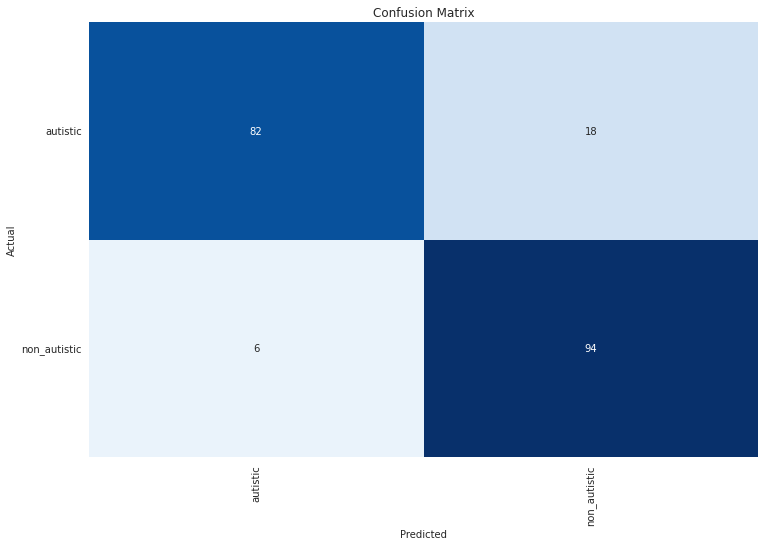

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic     0.9318    0.8200    0.8723       100
non_autistic     0.8393    0.9400    0.8868       100

    accuracy                         0.8800       200
   macro avg     0.8856    0.8800    0.8796       200
weighted avg     0.8856    0.8800    0.8796       200



In [7]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1, batch_size=1) #batch_size=1 performs predictions one by one so acquire less memory.
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

We achieved an F1 score of 83,6% which is not to bad considering we limited the number of images in train_df to 150  
images per class and reduced the image size to 200 X 282. This was done to reduce training time at the expense of the  
F1 score. Did model did better than I expected given that the labels for the images were probably done by a human or  
humans based on a visual rather than an analytic criteria.